# Tutorial 6: Transformers and Multi-Head Attention

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Under%20development&color=red)


**Filled notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.ipynb)  

In this tutorial, we will discuss one of the most impactful architectures of the last 2 years: the Transformer model. Since the paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762) by Vaswani et al. had been published in 2017, the Transformer architecture has continued to beat benchmarks in many domains, most importantly in Natural Language Processing. Transformers with an incredible amount of parameters can generate long, convincing [essays](https://www.theguardian.com/commentisfree/2020/sep/08/robot-wrote-this-article-gpt-3), and opened up new application fields of AI. As the hype of the Transformer architecture seems not to come to an end in the next years, it is important to understand how it works, and have implemented it yourself, which we will do in this notebook.

Despite the huge success of Transformers in NLP, we will _not_ include the NLP domain in our notebook here. Why? Firstly, the Master AI at UvA offers many great NLP courses that will take a closer look at the application of the Transformer architecture in NLP ([NLP2](https://studiegids.uva.nl/xmlpages/page/2020-2021/zoek-vak/vak/79628), [Advanced Topics in Computational Semantics](https://studiegids.uva.nl/xmlpages/page/2020-2021/zoek-vak/vak/80162)). Secondly, assignment 2 takes already a closer look at language generation on character level, on which you could easily apply our transformer architecture. Finally, and most importantly, there is so much more to the Transformer architecture. NLP is the domain the Transformer architecture has been originally proposed for and had the greatest impact on, but it also accelerated research in other domains, recently even [Computer Vision](https://arxiv.org/abs/2010.11929). Thus, we focus here on what makes the Transformer and self-attention so powerful in general.

Below, we import our standard libraries. As in Tutorial 5, we will use [PyTorch Lightning](https://www.pytorchlightning.ai/) as additional framework. If you are not familiar with PyTorch Lightning, please make sure to have read Tutorial 5 carefully.  

In [1]:
## Standard libraries
import os
import numpy as np 
import random
import math
import json
from functools import partial

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install pytorch-lightning==1.0.3
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial6"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Two pre-trained models are downloaded below. Make sure to have adjusted your `CHECKPOINT_PATH` before running this code if not already done.

In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial6/"
# Files to download
pretrained_files = ["ReverseTask.ckpt", "SetAnomalyTask.ckpt"]

# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print("Downloading %s..." % file_url)
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## The Transformer architecture

In the first part of this notebook, we will implement the Transformer architecture by hand. As the architecture is so popular, there already exists a Pytorch module `nn.Transformer` (documentation) and a [tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html) on how to use it for next token prediction. However, we will implement it here ourselves, to get through to the smallest details.

There are of course many more tutorials out there about attention and Transformers. Below, we list a few that are worth exploring if you are interested in the topic and might want yet another perspective on the topic after this one:

* [Transformer: A Novel Neural Network Architecture for Language Understanding (Jakob Uszkoreit, 2017)](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html) - The original Google blog post about the Transformer paper, focusing on the application in machine translation.
* [The Illustrated Transformer (Jay Alammar, 2018)](http://jalammar.github.io/illustrated-transformer/) - A very popular and great blog post intuitively explaining the Transformer architecture with many nice visualization. The focus is on NLP.
* [Attention? Attention! (Lilian Weng, 2018)](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html) - A nice blog post summarizing attention mechanisms in many domains including vision.
* [Illustrated: Self-Attention (Raimi Karim, 2019)](https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a) - A nice visualization of the steps of self-attention. Recommended to go through if the explanation below is too abstract for you.
* [The Transformer family (Lilian Weng, 2020)](https://lilianweng.github.io/lil-log/2020/04/07/the-transformer-family.html) - A very detailed blog post reviewing more variants of Transformers besides the original one.

### Scaled Dot Product Attention

The core concept behind self-attention is the scaled dot product attention. Our goal is to have an attention mechanism with which any element in a sequence can attend to any other while still being efficient to compute. The dot product attention takes as input a set of queries $Q\in\mathbb{R}^{T\times d_k}$, keys $K\in\mathbb{R}^{T\times d_k}$ and values $V\in\mathbb{R}^{T\times d_v}$ where $T$ is the sequence length, and $d_k$ and $d_v$ are the hidden dimensionality for queries/keys and values respectively. For simplicity, we neglect the batch dimension for now. You can imagine as if the query vectors represent what a specific element of the sequence is looking for in the others, the key vectors what each element "offers", and the value vectors the actual information each element provides. The attention value from element $i$ to $j$ is based on its similarity of the query $Q_i$ and key $K_j$, using the dot product as similarity metric. In math, we calculate the dot product attention as follows:

$$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

The matrix multiplication $QK^T$ performs the dot product for every possible pair of queries and keys, resulting in a matrix of the shape $T\times T$. Each row represents the attention logits for a specific element $i$ to all other elements in the sequence. On these, we apply a softmax and multiply with the value vector to obtain a weighted mean (the weights being determined by the attention). Another perspective on this attention mechanism offers the computation graph which is visualized below (figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).

<center width="100%"><img src="scaled_dot_product_attn.svg" width="210px"></center>

One aspect we haven't discussed yet is the scaling factor of $1/\sqrt{d_k}$. This scaling factor is crucial to maintain an appropriate variance of attention values after initialization. Remember that we intialize our layers with the intention of having equal variance throughout the model, and hence, $Q$ and $K$ might also have a variance close to $1$. However, performing a dot product over two vectors with a variance $\sigma$ results in a scalar having $d_k$-times higher variance: 

$$q_i \sim \mathcal{N}(0,\sigma), k_i \sim \mathcal{N}(0,\sigma) \to \text{Var}\left(\sum_{i=1}^{d_k} q_i\cdot k_i\right) = \sigma\cdot d_k$$


If we do not scale down the variance back to $\sigma$, the softmax over the logits will already saturate to $1$ for one random element, and $0$ for all others. The gradients through the softmax will be close to zero, so that we can't learn the parameters appropriately. 

The block `Mask (opt.)` in the diagram above represents an optional masking of specific entries in the attention matrix. This is for instance used if we stack multiple sequences with different lengths into a batch. To still benefit from parallelization in PyTorch, we pad the sentences to the same length, and mask out the padding tokens during the calculation of the attention values. This is usually done by setting the respective attention logits to a very low value. 

After we have discussed the details of the scaled dot product attention block, we can write a function below which computes the output features given the triple of queries, keys, and values:

In [3]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

Note that our code above supports any additional dimensionality in front of the sequence length, so that we can also use it for batches. However, for a better understanding, let's generate a few random query, key and value vectors, and calculate the attention outputs:

In [4]:
seq_len, d_k = 3, 2
pl.seed_everything(42)
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Q
 tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]])
K
 tensor([[ 2.2082, -0.6380],
        [ 0.4617,  0.2674],
        [ 0.5349,  0.8094]])
V
 tensor([[ 1.1103, -1.6898],
        [-0.9890,  0.9580],
        [ 1.3221,  0.8172]])
Values
 tensor([[ 0.5698, -0.1520],
        [ 0.5379, -0.0265],
        [ 0.2246,  0.5556]])
Attention
 tensor([[0.4028, 0.2886, 0.3086],
        [0.3538, 0.3069, 0.3393],
        [0.1303, 0.4630, 0.4067]])


Before continuing, make sure you can follow the calcululation of the specific values here, and also check it by hand. It is important that you have fully understood how the scaled dot product attention is calculated.

### Multi-Head Attention

The scaled dot product attention allows a network to attend over a sequence. However, often there are multiple different aspects a sequence element wants to attend to, and a single weighted average is not a good option for it. This is why we extend the attention mechanisms to multiple heads, i.e. multiple different query-key-value triplets on the same features. Specifically, given a query, key and value matrix, we transform those into $h$ sub-queries, sub-keys and sub-values, which we pass through the scaled dot product attention independently. Afterward, we concatenate the heads, and combine them with a final weight matrix. Mathematically, we can express this operation as:

$$
\begin{split}
    \text{Multihead}(Q,K,V) & = \text{Concat}(\text{head}_1,...,\text{head}_h)W^{O}\\
    \text{where} \text{head}_i & = \text{Attention}(QW_i^Q,KW_i^K, VW_i^V)
\end{split}
$$

We refer to this as Multi-Head Attention layer with the learnable parameters $W_{1...h}^{Q}\in\mathbb{R}^{D\times d_k}$, $W_{1...h}^{K}\in\mathbb{R}^{D\times d_k}$, $W_{1...h}^{V}\in\mathbb{R}^{D\times d_v}$, and $W^{O}\in\mathbb{R}^{h\cdot d_k\times d_{out}}$ ($D$ being the input dimensionality). Expressed in a computational graph, we can visualize it as below (figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).

<center width="100%"><img src="multihead_attention.svg" width="230px"></center>

How are we applying a Multi-Head Attention layer in a neural network, where we don't have an arbitrary query, key and value vector as input? Looking at the computation graph above, a simple but effective implementation is to set the current feature map in a NN, $X\in\mathbb{R}^{B\times T\times d_{\text{model}}}$, as $Q$, $K$ and $V$ ($B$ being the batch size, $T$ the sequence length, $d_{\text{model}}$ the hidden dimensionality of $X$). The consecutive weight matrices $W^{Q}$, $W^{K}$ and $W^{V}$ can transform $X$ to the corresponding feature vectors that represent the queries, keys and values of the input. Using this approach, we can implement the Multi-Head Attention module below.

In [5]:
class MultiheadAttention(nn.Module):
    
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)
        
        self._reset_parameters()
        
        
    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)
        
        
    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_proj(x)
        
        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)
        
        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)
        
        if return_attention:
            return o, attention
        else:
            return o

One crucial characteristic of the multi-head attention is that it is permutation-equivariant with respect to its inputs. This means that if we switch two input elements in the sequence, e.g. $X_1\leftrightarrow X_2$ (neglecting the batch dimension for now), the output is exactly the same besides the elements 1 and 2 switched. Hence, the multi-head attention is actually looking at the input not as a sequence, but as a set of elements. This property makes the multi-head attention block and the Transformer architecture so powerful and widely applicable! But what if the order of the input is actually important for solving the task, like language modeling? The answer is to encode the position in the input features, which we will take a closer look later (topic _Positional encodings_ below).

Before moving on to creating the Transformer architecture, we can compare the self-attention operation with our other common layer competitors for sequence data: convolutions and recurrent neural networks. Below you can find a table by [Vaswani et al. (2017)](https://arxiv.org/abs/1706.03762) on the complexity per layer, number of sequential operations and maximum path length. The complexity is measured by the upper bound of the number of operations to perform, while the maximum path length represents the maximum number of steps a forward or backward signal has to traverse to reach any other position. The lower this length, the better gradient signals can backpropagate for long-range dependencies. Let's take a look at the table below:


<center width="100%"><img src="comparison_conv_rnn.svg" width="600px"></center>

$n$ is the sequence length, $d$ is the representation dimension and $k$ is the kernel size of convolutions. In contrast to recurrent networks, self-attention layer can parallelize all its operations making it much faster to execute for smaller sequence lengths. However, when the sequence length exceeds the hidden dimensionality, self-attention becomes more expensive than RNNs. One way of reducing the computational cost for long sequences is by restricting the self-attention to a neighborhood of inputs to attend over, denoted by $r$. Nevertheless, there has been recently a lot of work on more efficient Transformer architectures that still allow long dependencies, of which you can find an overview in the paper by [Tay et al. (2020)](https://arxiv.org/abs/2009.06732) if interested.

### Transformer Encoder

Next, we will look at how to apply the multi-head attention blog inside the Transformer architecture. Originally, the Transformer model was designed for machine translation. Hence, it got an encoder-decoder structure where the encoder takes as input the sentence in the original language, and generates an attention-based representation. On the other hand, the decoder attends over the encoded information and generates the translated sentence in an autoregressive manner, as in a standard RNN. While this structure is extremely useful for Sequence-to-Sequence tasks with the necessity of an autoregressive decoding, we will focus here on the encoder part. Many advances in NLP have been made using a pure encoder-based Transformer models (if interested, models include the [BERT](https://arxiv.org/abs/1810.04805)-family, the [Vision Transformer](https://arxiv.org/abs/2010.11929), and more), and in our tutorial, we will also mainly focus on the encoder part. If you have understood the encoder architecture, the decoder is a very small step to implement as well. The full Transformer architecture looks as follows (figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).:

<center width="100%"><img src="transformer_architecture.svg" width="400px"></center>

The encoder is build up of $N$ identical blocks that are applied in sequence. Taking as input $x$, it is first passed through a Multi-Head Attention block as we have implemented above. The output is added to the original input using a residual connection, and we apply a consecutive Layer Normalization on the sum. Overall, it calculates $\text{LayerNorm}(x+\text{Multihead}(x,x,x))$ ($x$ being $Q$, $K$ and $V$ input to the attention layer). The residual connection is crucial in the Transformer architecture for two reasons: 

1. Similar to ResNets, Transformers are designed to be very deep. Some models contain more than 24 blocks in the encoder. Hence, the residual connections are crucial for enabling a smooth gradient flow through the model.
2. Without the residual connection, the information about the original sequence is lost. Remember that the Multi-Head Attention layer ignores the position of elements in a sequence, and can only learn it based on the input features. Removing the residual connections would mean that this information is lost after the first attention layer (after initialization), and with a randomly initialized query and key vector, the output vectors for position $i$ has no relation to its original input. All outputs of the attention are likely to represent similar/same information, and there is no chance for the model to distinguish which information came from which input element. An alternative option to residual connection would be to fix at least one head to focus on its original input, but this is very inefficient, and does not have the benefit of the improved gradient flow.

The Layer Normalization also plays an important role in the Transformer architecture as it enables faster training and provides small regularization. Additionally, it ensures that the features are in a similar magnitude among the elements in the sequence. We are not using Batch Normalization because it depends on the batch size which is often small with Transformers (they require a lot of GPU memory), and BatchNorm has shown to perform particularly bad in language as the features of words tend to have a much higher variance (there are many, very rare words which need to be considered for a good distribution estimate).

Additionally to the Multi-Head Attention, a small fully connected feed-forward network is added to the model, which is applied to each position separately and identically. Specifically, the model uses a Linear$\to$ReLU$\to$Linear MLP. The full transformation including the residual connection can be expressed as:  

$$
\begin{split}
    \text{FFN}(x) & = \max(0, xW_1+b_1)W_2 + b_2\\
    x & = \text{LayerNorm}(x + \text{FFN}(x))
\end{split}
$$

This MLP adds extra complexity to the model, and allows transformations on each sequence element separately. You can imagine as this allows the model to "post-process" the new information added by the previous Multi-Head Attention, and prepare it for the next attention block. Usually, the inner dimensionality of the MLP is 2-8$\times$ larger than $d_{\text{model}}$, i.e. the dimensionality of the original input $x$. The general advantage of a wider layer instead of a narrow, multi-layer MLP is the faster, parallelizable execution.

Finally, after looking at all parts of the encoder architecture, we can start implementing it below. We first start with implementing a single encoder block. Additionally to the layers described above, we will add dropout layers in the MLP and on the output of the MLP and Multi-Head Attention for regularization.

In [6]:
class EncoderBlock(nn.Module):
    
    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()
        
        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)
        
        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )
        
        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)
        
        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)
        
        return x

Based on this block, we can implement a module for the full Transformer encoder. Additionally to a forward function which iterates through the sequence of encoder blocks, we also provide a function called `get_attention_maps`. The idea of this function is to return the attention probabilities for all Multi-Head Attention block in the encoder. This helps us in understanding, and in a sense, explaining the model. However, the attention probabilities should be interpreted with a grain of salt as it does not necessarily reflect the true interpretation of the model (there is a series of papers about this, including [Attention is not Explanation](https://arxiv.org/abs/1902.10186) and [Attention is not not Explanation](https://arxiv.org/abs/1908.04626)).

In [7]:
class TransformerEncoder(nn.Module):
    
    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])
        
    
    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x
    
    
    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps

### Positional encoding

We have discussed before that the Multi-Head Attention block is permutation-equivariant, and cannot distinguish whether an input comes before another one in the sequence or not. In tasks like language understanding, however, the position is important for interpreting the input words. The position information can therefore be added via the input features. We could learn a embedding for every possible position, but this would not generalize to a dynamical input sequence length. Hence, the better option is to use feature patterns that the network can identify from the features and potentially generalize to larger sequences. The specific pattern chosen by Vaswani et al. are sine and cosine functions of different frequencies, as follows:

$$
PE_{(pos,i)} = \begin{cases}
    \sin\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right) & \text{if}\hspace{3mm} i \text{ mod } 2=0\\
    \cos\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right) & \text{otherwise}\\
\end{cases}
$$

$PE_{(pos,i)}$ represents the position encoding at position $pos$ in the sequence, and hidden dimensionality $i$. These values, concatenated for all hidden dimensions, are added to the original input features (in the Transformer visualization above, see "Positional encoding"), and constitute the position information. We distinguish between even ($i \text{ mod } 2=0$) and uneven ($i \text{ mod } 2=1$) hidden dimensionalities where we apply a sine/cosine respectively. The intuition behind this encoding is that you can represent $PE_{(pos+k,:)}$ as a linear function of $PE_{(pos,:)}$, which might allow the model to easily attend to relative positions. The wavelengths in different dimensions range from $2\pi$ to $10000\cdot 2\pi$.

The positional encoding is implemented below. The code is taken from the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html#define-the-model) about Transformers on NLP, and adjusted for our purposes.

In [8]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        
        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model) 
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

To understand the positional encoding, we can visualize it below. We will generate an image of the positional encoding over hidden dimensionality and position in a sequence. Each pixel therefore represents the change of the input feature we perform to encode the specific position. Let's do it below.

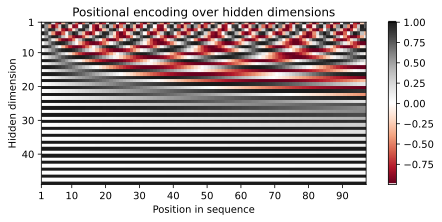

In [9]:
encod_block = PositionalEncoding(d_model=48, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

You can clearly see the sine and cosine waves with different wave lenghts that encode the position in the hidden dimensions. Specifically, we can look at the sine/cosine wave for each hidden dimension separately, to get a better intuition of the pattern. Below we visualize the positional encoding for the hidden dimensions $1$, $2$, $3$ and $4$.

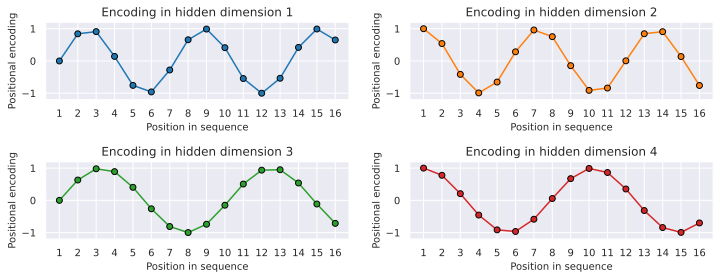

In [10]:
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), pe[i,:16], color='C%i'%i, marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title("Encoding in hidden dimension %i" % (i+1))
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

As we can see, the patterns between hidden dimension $1$ and $2$ only differ in the starting angle. The wavelength is $2\pi$, hence the repition after position $6$. The hidden dimensions $2$ and $3$ have about twice the wavelength. 

### Learning rate warm-up

One commonly used technique for training a Transformer is learning rate warm-up. This means that we gradually increase the learning rate from 0 on to our originally specified learning rate in the first few iteration. Thus, we slowly start learning instead of taking very large steps from the beginning on. In fact, training a deep Transformer without learning rate warm-up can make the model and achieve a much worse performance on training and testing. Take for instance the following plot by [Liu et al. (2019)](https://arxiv.org/pdf/1908.03265.pdf) comparing Adam-vanilla (i.e. Adam without warm-up) vs Adam with warm-up:

<center width="100%"><img src="warmup_loss_plot.svg" width="350px"></center>

Clearly, warm-up is a crucial hyperparameter in Transformer architecture. Why is it so important? There are currently two common explanations. Firstly, Adam uses the bias correction factors which however can lead to a higher variance in the adaptive learning rate during the first iterations. Improved optimizers like [RAdam](https://arxiv.org/abs/1908.03265) have shown to overcome this issue, not requiring warm-up for training Transformers. Secondly, the iteratively applied Layer Normalization across layers can lead to very high gradients during the first iterations, which can be solved by using [Pre-Layer Normalization](https://proceedings.icml.cc/static/paper_files/icml/2020/328-Paper.pdf) (similar to Pre-Activation ResNet), or replacing Layer Normalization by other techniques ([Adaptive Normalization](https://proceedings.icml.cc/static/paper_files/icml/2020/328-Paper.pdf), [Power Normalization](https://arxiv.org/abs/2003.07845)). 

Nevertheless, many applications and papers still use the original Transformer architecture with Adam, because warm-up is a simple, yet effective way of solving the gradient problem in the first iterations. There are many different schedulers we could use. For instance, the original Transformer paper used a exponential decay scheduler with warm-up. However, the currently most popular scheduler is the cosine warm-up scheduler, which combines warm-up with a cosine-shaped learning rate decay. We can implement it below, and visualize the learning rate factor over epochs. 

In [11]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):
    
    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)
        
    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]
    
    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

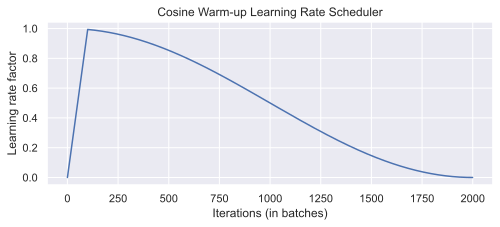

In [12]:
# Needed for initializing the lr scheduler
p = nn.Parameter(torch.empty(4,4))
optimizer = optim.Adam([p], lr=1e-3)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

In the first 100 iterations, we increase the learning rate factor from to to 1, whereas for all later iterations, we decay it using the cosine wave. Pre-implementations of this scheduler can be found in the popular NLP Transformer library [huggingface](https://huggingface.co/transformers/main_classes/optimizer_schedules.html?highlight=cosine#transformers.get_cosine_schedule_with_warmup).

### PyTorch Lightning Module

Finally, we can embed the Transformer architecture into a PyTorch lightning module. From Tutorial 5, you know that PyTorch Lightning simplifies our training and test code, as well as structures the code nicely in separate functions. We will implement a template for a classifier based on the Transformer encoder. Thereby, we have a prediction output per sequence element. If we would need a classifier over the whole sequence, the common approach is to add an additional `[CLS]` token to the sequence, representing the classifier token. However, here we focus on tasks where we have an output per element. 

Additionally to the Transformer architecture, we add a small input network (maps input dimensions to model dimensions), the positional encoding, and an output network (transforms output encodings to predictions). We also add the learning rate scheduler, which takes a step each iteration instead of once per epoch. This is needed for the warmup and the smooth cosine decay. The training, validation and test step is left empty for now, and will be filled for our task-specific models.

In [13]:
class TransformerPredictor(pl.LightningModule):
    
    
    def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, lr, warmup, max_iters, dropout=0.0, input_dropout=0.0):
        """
        Inputs:
            input_dim - Hidden dimensionality of the input
            model_dim - Hidden dimensionality to use inside the Transformer
            num_classes - Number of classes to predict per sequence element
            num_heads - Number of heads to use in the Multi-Head Attention blocks
            num_layers - Number of encoder blocks to use.
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout - Dropout to apply inside the model
            input_dropout - Dropout to apply on the input features
        """
        super().__init__()
        self.save_hyperparameters()
        self._create_model()
        
    
    def _create_model(self):
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Dropout(self.hparams.input_dropout),
            nn.Linear(self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=self.hparams.model_dim)
        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.hparams.num_layers,
                                              input_dim=self.hparams.model_dim,
                                              dim_feedforward=2*self.hparams.model_dim,
                                              num_heads=self.hparams.num_heads,
                                              dropout=self.hparams.dropout)
        # Output classifier per sequence lement
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hparams.dropout),
            nn.Linear(self.hparams.model_dim, self.hparams.num_classes)
        ) 
        
    
    def forward(self, x, mask=None, add_positional_encoding=True):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
        return x
    
    
    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps
    
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)
        
        # We don't return the lr scheduler because we need to apply it per iteration, not per epoch
        self.lr_scheduler = CosineWarmupScheduler(optimizer, 
                                                  warmup=self.hparams.warmup, 
                                                  max_iters=self.hparams.max_iters)
        return optimizer
    
    
    def optimizer_step(self, *args, **kwargs):
        super().optimizer_step(*args, **kwargs)
        self.lr_scheduler.step() # Step per iteration
    
    
    def training_step(self, batch, batch_idx):
        raise NotImplementedError
    
    
    def validation_step(self, batch, batch_idx):
        raise NotImplementedError    
    
    
    def test_step(self, batch, batch_idx):
        raise NotImplementedError   

## Tasks

### Sequence to Sequence

* Toy dataset: reverse input

In [14]:
class ReverseDataset(data.Dataset):
    
    
    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size
        
        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))
        
        
    def __len__(self):
        return self.size
    
    
    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels

In [15]:
dataset = partial(ReverseDataset, 10, 16)
train_loader = data.DataLoader(dataset(50000), batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader   = data.DataLoader(dataset(1000), batch_size=128)
test_loader  = data.DataLoader(dataset(10000), batch_size=128)

In [16]:
train_loader.dataset[0]

(tensor([9, 6, 2, 0, 6, 2, 7, 9, 7, 3, 3, 4, 3, 7, 0, 9]),
 tensor([9, 0, 7, 3, 4, 3, 3, 7, 9, 7, 2, 6, 0, 2, 6, 9]))

In [17]:
class ReversePredictor(TransformerPredictor):
    
    def _calculate_loss(self, batch, mode="train"):
        inp_data, labels = batch
        inp_data = F.one_hot(inp_data, num_classes=self.hparams.num_classes).float()
        preds = self.forward(inp_data, add_positional_encoding=True)
        loss = F.cross_entropy(preds.view(-1,preds.size(-1)), labels.view(-1))
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        self.log("%s_loss" % mode, loss)
        self.log("%s_acc" % mode, acc)
        return loss, acc
        
    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")
    
    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

In [18]:
def train_reverse(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "ReverseTask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir, 
                         checkpoint_callback=ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                         gpus=1, 
                         max_epochs=10,
                         progress_bar_refresh_rate=1)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ReverseTask.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = ReversePredictor.load_from_checkpoint(pretrained_filename)
    else:
        model = ReversePredictor(max_iters=trainer.max_epochs*len(train_loader), **kwargs)
        trainer.fit(model, train_loader, val_loader)
    # Test best model on validation and test set
    val_result = trainer.test(model, test_dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"]}
    return model, result

In [19]:
reverse_model, reverse_result = train_reverse(input_dim=train_loader.dataset.num_categories,
                                              model_dim=32,
                                              num_heads=1,
                                              num_classes=train_loader.dataset.num_categories,
                                              num_layers=1,
                                              dropout=0.0,
                                              lr=5e-4,
                                              warmup=50)
print(reverse_result)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model, loading...


/home/phillip/anaconda3/envs/nlp1/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)



{'test_acc': 1.0, 'val_acc': 1.0}


In [20]:
data_input, labels = next(iter(val_loader))
inp_data = F.one_hot(data_input, num_classes=reverse_model.hparams.num_classes).float()
inp_data = inp_data.to(device)
attention_maps = reverse_model.get_attention_maps(inp_data)

In [21]:
attention_maps[0].shape

torch.Size([128, 1, 16, 16])

In [22]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]
    
    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title("Layer %i, Head %i" % (row+1, column+1))
    fig.subplots_adjust(hspace=0.5)
    plt.show()

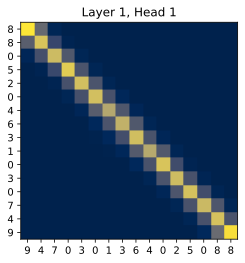

In [23]:
plot_attention_maps(data_input, attention_maps, idx=0)

### Set anomaly detection

* Given set of images, which ones doesn't fit in?

In [24]:
DATA_MEANS = np.array([0.485, 0.456, 0.406])
DATA_STD = np.array([0.229, 0.224, 0.225])
TORCH_DATA_MEANS = torch.from_numpy(DATA_MEANS).view(1,3,1,1)
TORCH_DATA_STD = torch.from_numpy(DATA_STD).view(1,3,1,1)
transform = transforms.Compose([transforms.Resize((224,244)),
                                transforms.ToTensor(),
                                transforms.Normalize(DATA_MEANS, DATA_STD)
                                ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_set = CIFAR100(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = CIFAR100(root=DATASET_PATH, train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
import os
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(pretrained=True)
# Remove classification layer
pretrained_model.fc = nn.Sequential()
pretrained_model.classifier = nn.Sequential()
# To GPU
pretrained_model = pretrained_model.to(device)

# Only eval
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

In [26]:
@torch.no_grad()
def extract_features(dataset, save_file):
    if not os.path.isfile(save_file):
        data_loader = data.DataLoader(dataset, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
        extracted_features = []
        for imgs, _ in tqdm(data_loader):
            imgs = imgs.to(device)
            feats = pretrained_model(imgs)
            extracted_features.append(feats)
        extracted_features = torch.cat(extracted_features, dim=0)
        extracted_features = extracted_features.detach().cpu()
        torch.save(extracted_features, save_file)
    else:
        extracted_features = torch.load(save_file)
    return extracted_features

train_feat_file = os.path.join(CHECKPOINT_PATH, "train_set_features.tar")
train_set_feats = extract_features(train_set, train_feat_file)

test_feat_file = os.path.join(CHECKPOINT_PATH, "test_set_features.tar")
test_feats = extract_features(test_set, test_feat_file)

In [27]:
print(train_set_feats.shape)
print(test_feats.shape)

torch.Size([50000, 512])
torch.Size([10000, 512])


In [28]:
# Split train into train+val
labels = train_set.targets

labels = torch.LongTensor(labels)
num_labels = labels.max()+1
sorted_indices = torch.argsort(labels).reshape(num_labels, -1)

num_val_exmps = sorted_indices.shape[1] // 10

val_indices   = sorted_indices[:,:num_val_exmps].reshape(-1)
train_indices = sorted_indices[:,num_val_exmps:].reshape(-1)

train_feats, train_labels = train_set_feats[train_indices], labels[train_indices]
val_feats,   val_labels   = train_set_feats[val_indices],   labels[val_indices]

In [29]:
class SetAnomalyDataset(data.Dataset):
    
    def __init__(self, img_feats, labels, set_size=5, train=True):
        super().__init__()
        self.img_feats = img_feats
        self.labels = labels
        self.set_size = set_size-1 # The set size is here the size of correct images
        self.train = train
        
        self.num_labels = labels.max()+1
        self.img_idx_by_label = torch.argsort(self.labels).reshape(self.num_labels, -1)
        
        if not train:
            self.test_sets = self._create_test_sets()
            
            
    def _create_test_sets(self):
        test_sets = []
        num_imgs = self.img_feats.shape[0]
        np.random.seed(42)
        test_sets = [self.sample_img_set(self.labels[idx]) for idx in range(num_imgs)]
        test_sets = torch.stack(test_sets, dim=0)
        return test_sets
            
        
    def sample_img_set(self, anomaly_label):
        set_label = np.random.randint(self.num_labels-1)
        if set_label >= anomaly_label:
            set_label += 1
        img_indices = np.random.choice(self.img_idx_by_label.shape[1], size=self.set_size, replace=False)
        img_indices = self.img_idx_by_label[set_label, img_indices]
        return img_indices
        
        
    def __len__(self):
        return self.img_feats.shape[0]
    
    
    def __getitem__(self, idx):
        anomaly = self.img_feats[idx]
        if self.train:
            img_indices = self.sample_img_set(self.labels[idx])
        else:
            img_indices = self.test_sets[idx]
            
        img_set = torch.cat([self.img_feats[img_indices], anomaly[None]], dim=0)
        indices = torch.cat([img_indices, torch.LongTensor([idx])], dim=0)
        label = img_set.shape[0]-1
        return img_set, indices, label

In [30]:
SET_SIZE = 10
test_labels = torch.LongTensor(test_set.targets)

train_anom_dataset = SetAnomalyDataset(train_feats, train_labels, set_size=SET_SIZE, train=True)
val_anom_dataset   = SetAnomalyDataset(val_feats,   val_labels,   set_size=SET_SIZE, train=False)
test_anom_dataset  = SetAnomalyDataset(test_feats,  test_labels,  set_size=SET_SIZE, train=False)

train_anom_loader = data.DataLoader(train_anom_dataset, batch_size=64, shuffle=True,  drop_last=True,  num_workers=4, pin_memory=True)
val_anom_loader   = data.DataLoader(val_anom_dataset,   batch_size=64, shuffle=False, drop_last=False, num_workers=4)
test_anom_loader  = data.DataLoader(test_anom_dataset,  batch_size=64, shuffle=False, drop_last=False, num_workers=4)

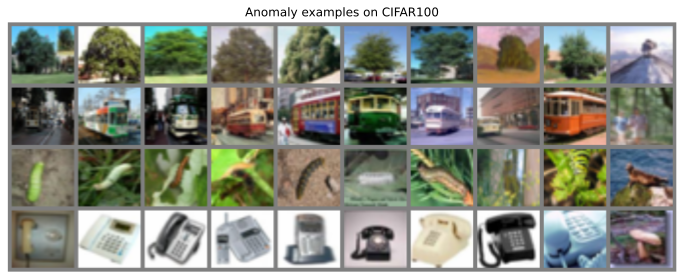

In [31]:
def visualize_exmp(indices, orig_dataset):
    images = [orig_dataset[idx][0] for idx in indices.reshape(-1)]
    images = torch.stack(images, dim=0)
    images = images * TORCH_DATA_STD + TORCH_DATA_MEANS
    
    img_grid = torchvision.utils.make_grid(images, nrow=SET_SIZE, normalize=True, pad_value=0.5, padding=16)
    img_grid = img_grid.permute(1, 2, 0)

    plt.figure(figsize=(12,8))
    plt.title("Anomaly examples on CIFAR100")
    plt.imshow(img_grid)
    plt.axis('off')
    plt.show()
    plt.close()

_, indices, _ = next(iter(test_anom_loader))
visualize_exmp(indices[:4], test_set)

In [32]:
class AnomalyPredictor(TransformerPredictor):
    
    def _calculate_loss(self, batch, mode="train"):
        img_sets, _, labels = batch
        preds = self.forward(img_sets, add_positional_encoding=False)
        preds = preds.squeeze(dim=-1)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        self.log("%s_loss" % mode, loss)
        self.log("%s_acc" % mode, acc, on_step=False, on_epoch=True)
        return loss, acc
        
    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")
    
    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

In [33]:
def train_anomaly(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "SetAnomalyTask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir, 
                         checkpoint_callback=ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
                         gpus=1, 
                         max_epochs=50,
                         progress_bar_refresh_rate=1)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need
    
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "SetAnomalyTask.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = AnomalyPredictor.load_from_checkpoint(pretrained_filename)
    else:
        model = AnomalyPredictor(max_iters=trainer.max_epochs*len(train_anom_loader), **kwargs)
        trainer.fit(model, train_anom_loader, val_anom_loader)
        model = AnomalyPredictor.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    # Test best model on validation and test set
    train_result = trainer.test(model, test_dataloaders=train_anom_loader, verbose=False)
    val_result = trainer.test(model, test_dataloaders=val_anom_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=test_anom_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"], "train_acc": train_result[0]["test_acc"]}
    return model, result

In [34]:
anomaly_model, anomaly_result = train_anomaly(input_dim=train_anom_dataset.img_feats.shape[-1],
                                              model_dim=256,
                                              num_heads=4,
                                              num_classes=1,
                                              num_layers=4,
                                              dropout=0.1,
                                              input_dropout=0.1,
                                              lr=5e-4,
                                              warmup=100)

GPU available: True, used: True
I1107 20:57:42.123372 140404495931200 distributed.py:49] GPU available: True, used: True
TPU available: False, using: 0 TPU cores
I1107 20:57:42.124821 140404495931200 distributed.py:49] TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
I1107 20:57:42.125875 140404495931200 accelerator_connector.py:385] LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Found pretrained model, loading...


/home/phillip/anaconda3/envs/nlp1/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


In [35]:
print("Train accuracy: %4.2f%%" % (100.0*anomaly_result["train_acc"]))
print("Val accuracy:   %4.2f%%" % (100.0*anomaly_result["val_acc"]))
print("Test accuracy:  %4.2f%%" % (100.0*anomaly_result["test_acc"]))

Train accuracy: 97.77%
Val accuracy:   94.38%
Test accuracy:  94.30%


In [36]:
inp_data, indices, labels = next(iter(test_anom_loader))
inp_data = inp_data.to(device)
attention_maps = anomaly_model.get_attention_maps(inp_data, add_positional_encoding=False)
predictions = anomaly_model(inp_data, add_positional_encoding=False).squeeze().argmax(dim=-1)

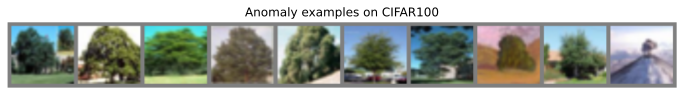

Prediction: 9


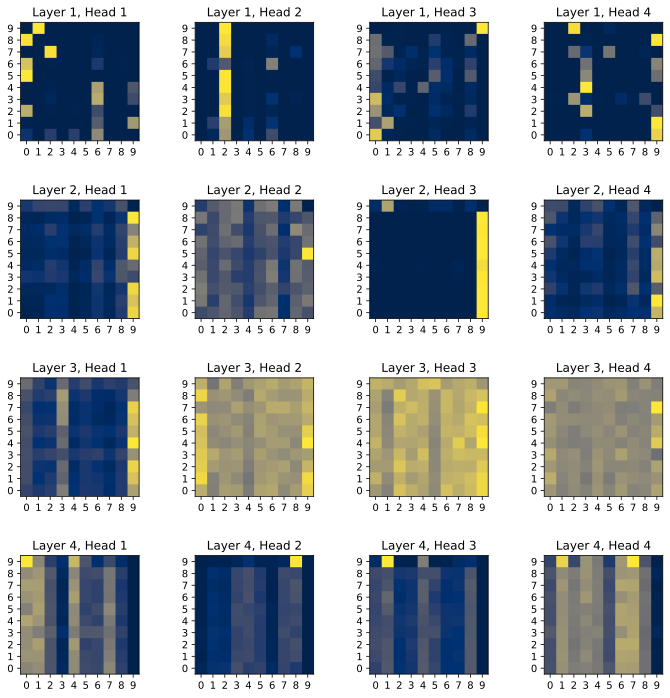

In [37]:
def visualize_prediction(idx):
    visualize_exmp(indices[idx:idx+1], test_set)
    print("Prediction:", predictions[idx].item())
    plot_attention_maps(input_data=None, attn_maps=attention_maps, idx=idx)

visualize_prediction(0)

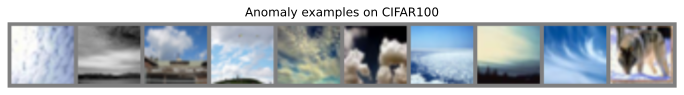

Prediction: 9


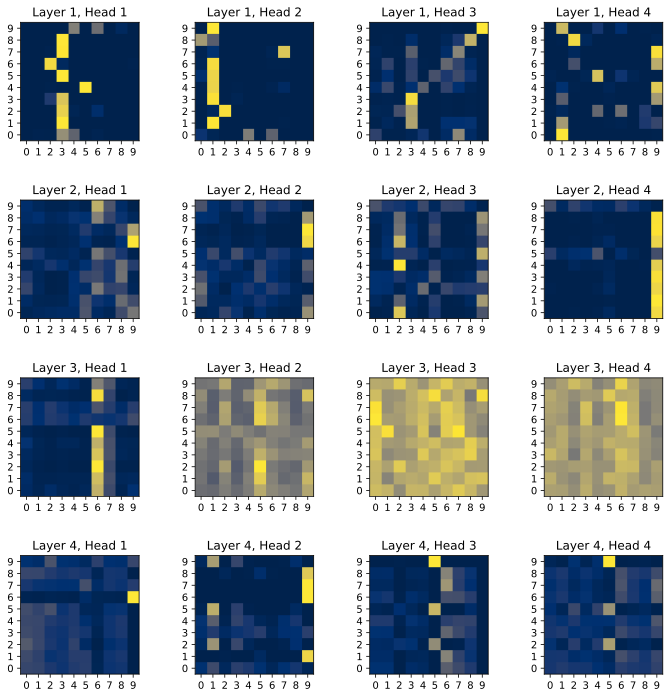

In [38]:
visualize_prediction(17)

In [39]:
predictions

tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 2, 9, 9, 9, 9, 9, 3, 9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9,
        7, 2, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0')